In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
import sys
sys.path.append("..")
sys.path.insert(0, Path.cwd().parent)
sns.set()

##### Load data from a trained NN

In [3]:
path = Path("../saved_models/model_231213-175916.pt")
training_data = torch.load(path, map_location="cpu")

Text(0, 0.5, 'Logical accuracy')

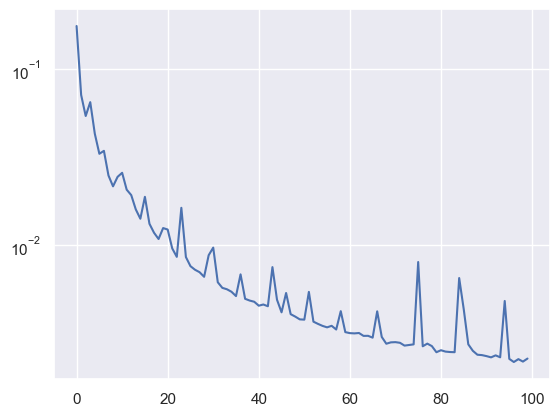

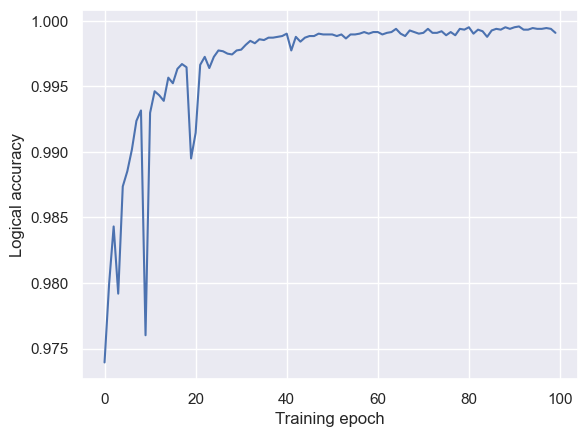

In [10]:
history = training_data["training_history"]
loss = history["loss"]
failure_rate = history["failure_rate"]
n_epochs = history["epoch"] + 1

fig, ax = plt.subplots()
t = range(n_epochs)
ax.semilogy(t, loss)

fig, ax = plt.subplots()
ax.plot(t, 1 - np.array(failure_rate))
ax.set_xlabel("Training epoch")
ax.set_ylabel("Logical accuracy")